In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u

from lenstools.simulations.fastpm import FastPMSnapshot 
from lenstools.simulations.raytracing import DensityPlane, PotentialPlane
from lenstools.image.convergence import ConvergenceMap

In [2]:
#Read in the snapshot
snap_path = "/Users/andreapetri/Documents/Cosmology_software/LensTools/SimTest/Storage/Om0.290_Ol0.710/128b128/ic1/snapshots/lightconeresult"
snap = FastPMSnapshot.open(snap_path)
snap.getPositions()

<Quantity [[  1.27618767e+02,  5.04905879e-01,  1.27383766e+02],
           [  1.26530273e+02,  4.09351444e+00,  1.93040812e+00],
           [  3.39050293e-02,  3.97269797e+00,  3.23024702e+00],
           ..., 
           [  1.26884491e+02,  1.27305405e+02,  1.24556503e+02],
           [  1.26888199e+02,  1.27430794e+02,  1.25522659e+02],
           [  1.26898415e+02,  1.27643196e+02,  1.26618202e+02]] Mpc/h>

## Cut a thin lens from the FastPM snapshot

In [3]:
#Location and thickness of the lens
plane_center = 60.*snap.Mpc_over_h
plane_thickness = 10.*snap.Mpc_over_h

plane_center,plane_thickness

(<Quantity 60.0 Mpc/h>, <Quantity 10.0 Mpc/h>)

In [4]:
#Cut a two dimensional lens
density_2d,res,npart = snap.cutPlaneGaussianGrid(normal=2,center=plane_center,thickness=plane_thickness,plane_resolution=64,kind="density")
potential_2d,res,npart = snap.cutPlaneGaussianGrid(normal=2,center=plane_center,thickness=plane_thickness,plane_resolution=64,kind="potential")

In [5]:
#Plane shape
density_2d.shape

(64, 64)

In [7]:
#Build PotentialPlane and DensityPlane instances
density_2d = DensityPlane(density_2d,angle=snap.header["box_size"],comoving_distance=plane_center)
potential_2d = PotentialPlane(potential_2d.value,angle=snap.header["box_size"],comoving_distance=plane_center,unit=u.rad**2)

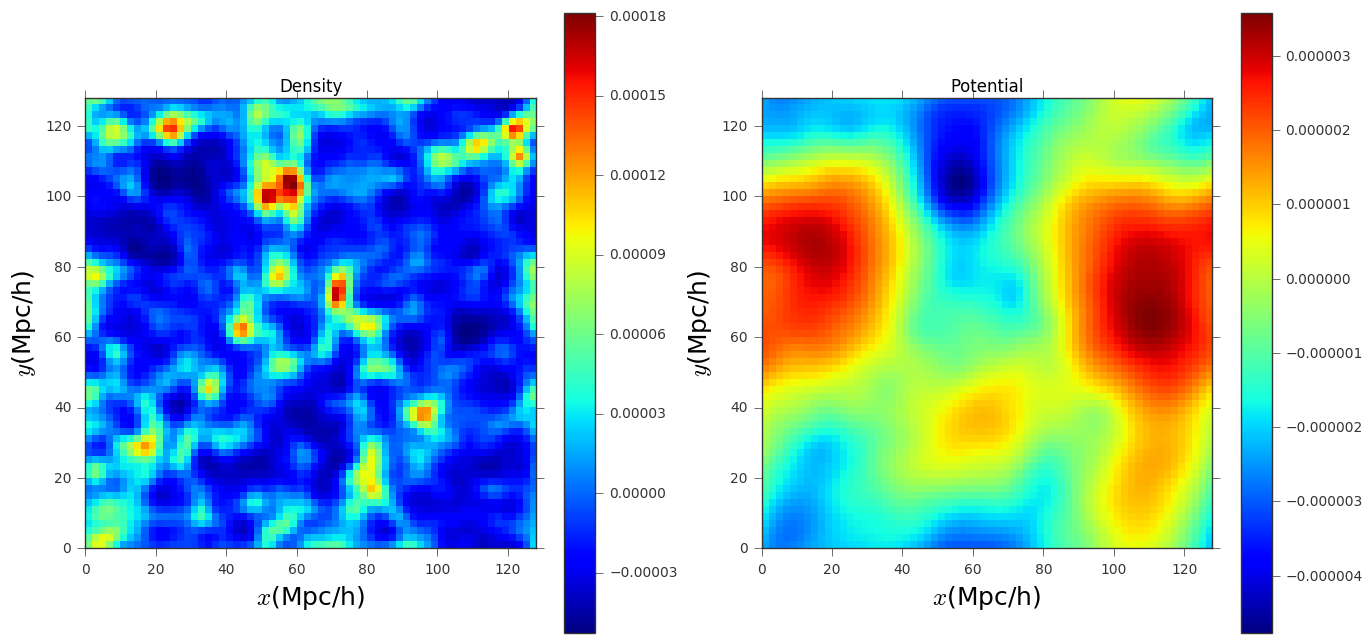

In [8]:
#Visualize
fig,ax = plt.subplots(1,2,figsize=(16,8))
density_2d.visualize(fig=fig,ax=ax[0],colorbar=True)
potential_2d.visualize(fig=fig,ax=ax[1],colorbar=True)

ax[0].set_title("Density")
ax[1].set_title("Potential")

## Perform a direct Born integration to get the convergence

In [3]:
#Integrate up to this redshift
z = 3.0
chi_max = snap.cosmology.comoving_distance(z)
chi_max

<Quantity 6227.352272514731 Mpc>

In [14]:
#Replace the z positions in the snapshot with the actual comoving distances for realistic integration
snap.positions[:,2] = snap.cosmology.comoving_distance(1./snap.aemit - 1).to(snap.positions.unit).astype(np.float32)

In [15]:
#Give each particle a weight corresponding to the lensing kernel
snap.weights = 1. - (snap.positions[:,2]/chi_max).decompose().value

In [16]:
#Perform the integration in one shot
convergence,res,npart = snap.cutPlaneGaussianGrid(normal=2,center=chi_max/2,thickness=chi_max,plane_resolution=256,kind="born")
convergence = ConvergenceMap(convergence,angle=res[0]*convergence.shape[0])

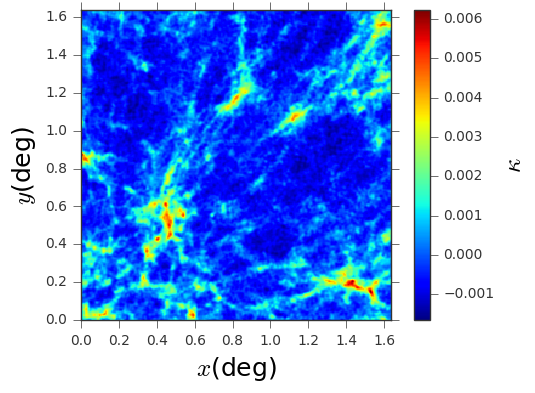

In [17]:
#Visualize
fig,ax = plt.subplots()
convergence.visualize(fig=fig,ax=ax,colorbar=True,cbar_label=r"$\kappa$")

In [9]:
#Close snapshot
snap.close()